Plots for Minimal Packing Set manuscript

In [1]:
from gsd_lib import GSD, MinimalPackingGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update(
    {
        # Figure settings
        "figure.figsize": (5, 4),
        "figure.dpi": 100,
        "savefig.dpi": 600,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.1,
        # Font settings
        "font.size": 12,
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": ["cmss10", "Arial"],
        # "font.serif": ["Latin Modern", "cmr10"],
        # "font.monospace": ["cmtt10"],
        "axes.formatter.use_mathtext": True,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        # Axes settings
        "axes.linewidth": 1.0,
        "axes.spines.top": True,
        "axes.spines.right": True,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "grid.linewidth": 0.5,
        # Line and marker settings
        "lines.linewidth": 1.5,
        "lines.markersize": 6,
        "scatter.marker": "o",
        # Legend settings
        "legend.frameon": True,
        "legend.framealpha": 0.8,
        "legend.fancybox": True,
        "legend.numpoints": 1,
        # Tick settings
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "xtick.minor.size": 2,
        "ytick.minor.size": 2,
    }
)

%matplotlib widget




In [2]:
# Standard U.S. sieve sizes (mm)
x1 = np.array(
    [
        0.0001,  # Pan
        0.075,  # Number 200 sieve separates coarse from fines
        0.15,
        0.3,
        0.6,
        1.18,
        2.36,
        4.75,  # Number 4 sieve separates sand from gravel
        9.5,
        19,
        25,
        37.5,
        50,
        63,
        75,  # 3-inch sieve (100% passing this per ASTM D2487-17 1.2)

    ]
)

sieve_sizes = x1.copy()
n_sieves = len(sieve_sizes)

In [24]:
# Generate random grain size distributions on the sieve set
def mass_dist(n_sieves, rng=None, exponent=4.0, extra_randomness = 0):
    if rng is None:
        rng = np.random.default_rng()
    base_dist = 1*np.ones(n_sieves)  + rng.random(n_sieves)
    lower = 1 + n_sieves // 4
    upper = 1 + 3 * n_sieves // 4
    center_idx = rng.integers(lower, upper)
    distances = np.abs(np.arange(n_sieves) - center_idx) / center_idx
    scale_factor = np.exp(-exponent * distances)
    dist = base_dist * scale_factor
    for i in range(extra_randomness):
        dist *= 1 + rng.random(n_sieves)   # Add some extra randomness
    return dist

# A random generator with a fixed seed for reproducibility
rng = np.random.default_rng(1)

tol = 1e-2

gsd_list = []
set_size_list = []
flex_list = []

# data_rows = []
x = x1.copy()
min_span = 5
for start in range(0, len(x) - min_span):
    for end in range(start + min_span, len(x)):
        new_x = x[start:end]
        n_sieves = len(new_x)

        for j in range(10):
            # Create a distributed set of retained masses
            mass = mass_dist(n_sieves, rng, exponent=2, extra_randomness=7)

            mass[-1] = 0.0  # Ensure last mass is zero
            g = GSD(sizes=new_x, masses=mass)

            # Create a flexible minimal packing for each GSD
            mps_f = MinimalPackingGenerator(
                g, x_n_factor=0.5, tol=tol, flex=True, density=1.0
            )

            # Create a set size minimal packing for each GSD
            mps_s = MinimalPackingGenerator(
                g, x_n_factor=0.5, tol=tol, flex=False, density=1.0
            )
            gsd_list.append(g)
            set_size_list.append(mps_s)
            flex_list.append(mps_f)
# for i in range(200):
#     # Create a distributed set of retained masses
#     mass = mass_dist(n_sieves, rng, exponent=2, extra_randomness=7)
#     mass[-1] = 0.0  # Ensure last mass is zero
#     g = GSD(sizes=sieve_sizes, masses=mass)
#     # Create a set size minimal packing for each GSD
#     s_set_size = MinimalPackingGenerator(
#         g, x_n_factor=0.01, tol=tol, flex=False, density=1.0
#     )
#     # Create a flexible minimal packing for each GSD
#     s_flex = MinimalPackingGenerator(
#         g, x_n_factor=0.01, tol=tol, flex=True, density=1.0
#     )
#     gsd_list.append(g)
#     set_size_list.append(s_set_size)
#     flex_list.append(s_flex)


(0.055, 100)

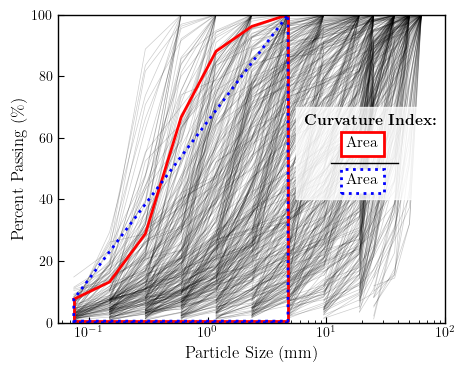

In [25]:
# Plot the grain size distributions
# plt.close('all')
fig, ax = plt.subplots()
for gsd in gsd_list:
    ax.plot(gsd.sizes[1:], 100*gsd.percent_passing[1:], color='k', alpha=0.2, linewidth=0.5)

ex_i = 39
example_gsd = gsd_list[ex_i]
ax.plot(example_gsd.sizes[1:], 100*example_gsd.percent_passing[1:], color='r', linewidth=2, label='Example GSD')
ax.plot(
    [
        example_gsd.sizes[1],
        example_gsd.sizes[1],
        example_gsd.sizes[-1],
        example_gsd.sizes[-1],
    ],
    [
        100 * example_gsd.percent_passing[1],
        0.5,
        0.5,
        100 * example_gsd.percent_passing[-1],
    ],
    color="r",
    linewidth=2,
    label="Example Retained",
)

ax.plot(
    [
        0.075,
        example_gsd.sizes[-1],
        example_gsd.sizes[-1],
        0.075,
        0.075,
        example_gsd.sizes[-1],
    ],
    [0.5, 0.5, 100, 100 * example_gsd.percent_passing[1], 0, 0],
    color="b",
    linestyle=":",
    linewidth=2,
    label="Uniform Distribution",
)

ax.plot([11,40], [52,52], color='k', linewidth=1,zorder=4)
left, bottom, width, height = (5.5, 40, 80, 30)
rect = plt.Rectangle((left, bottom), width, height, fill=True, color="1", alpha=0.8,zorder=3)

arrowprops = dict(arrowstyle="->", color="k", lw=1)
bbox = dict(fc="1", ec="1", alpha=0.9)


ax.add_patch(rect)
ax.annotate(
    r"\textbf{Curvature Index:}",
    xy=(5, 65),
    xytext=(6.5, 65),
    fontsize=11,
    # bbox=bbox,
    color="k",
    ha="left",
    va="center",
)
bbox = dict(fc="1", ec="r", linewidth=2, alpha=1)
ax.annotate(
    r"Area",
    xy=(5, 65),
    xytext=(20, 58),
    fontsize=11,
    bbox=bbox,
    color="k",
    ha="center",
    va="center",
)
bbox = dict(fc="1", ec="b", linestyle=":", linewidth=2, alpha=1)
ax.annotate(
    r"Area",
    xy=(5, 65),
    xytext=(20, 46),
    fontsize=11,
    bbox=bbox,
    color="k",
    ha="center",
    va="center",
)

ax.set_xscale('log')
ax.grid()#(True, which='both', axis='both')
ax.set_xlabel('Particle Size (mm)')
ax.set_ylabel(r'Percent Passing (\%)')
ax.set_ylim(0, 100)
ax.set_xlim(0.055, 100)

In [26]:
example_gsd.curvature_index

np.float64(1.0864045629929076)

The figure below shows the effectiveness of the spanning integer approach to finding the minimal packing set.
With the spanning integer approach, the error converges to zero rapidly (the final packing is generally not controlled by the user-specified tolerance) compared to the fixed size approach.


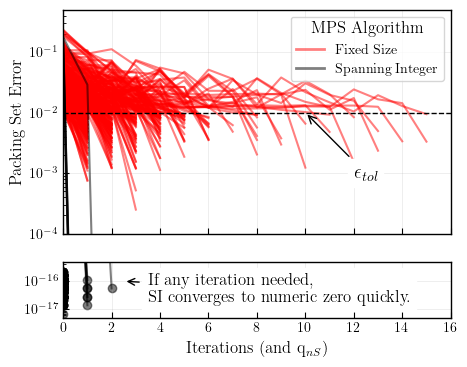

In [27]:

# Packing algorithm convergence plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[4, 1])
# fig, ax1 = plt.subplots()
j = 1
nf = []
ns = []

for i in range(len(set_size_list)):
    # f = flex_list[i]
    s = set_size_list[i]
    # xf = [n[-1] for n in f.qs]
    xs = [n[-1] - 1 for n in s.qs]
    # f_error = f.error
    s_error = s.error

    # nf.append(xf[-1])
    ns.append(xs[-1])
    # ax1.plot(xf, f.error, color="k", alpha=1)
    # ax2.plot(xf, f.error, color="k", alpha=0.5)
    ax1.plot(xs, s.error, color="r", alpha=0.5)

for i in range(len(flex_list)):
    f = flex_list[i]
    # s = set_size_list[i]
    xf = [n[-1] - 1 for n in f.qs]
    # xs = [n[-1] for n in s.qs]
    f_error = f.error
    # s_error = s.error

    nf.append(xf[-1])
    # ns.append(xs[-1])
    ax1.plot(xf, f.error, color="k", alpha=0.5)
    ax2.plot(xf, f.error, color="k", alpha=0.5)
    ax2.scatter(xf, f.error, marker="o", color="k", alpha=0.5)
    # ax1.plot(xs,s.error,color="r", alpha=1)


ax1.plot([0, 200], [tol, tol], color="k", linestyle="--", linewidth=1)


# # Calculate histograms
# counts_ns, bins_ns = np.histogram(ns, bins=50)
# counts_nf, bins_nf = np.histogram(nf, bins=bins_ns)

# # Normalize to max frequency
# norm_counts_ns = counts_ns / np.max(counts_ns)
# norm_counts_nf = counts_nf / np.max(counts_nf)

# # Plot normalized histograms
# ax2.bar(
#     bins_ns[:-1],
#     norm_counts_ns,
#     width=np.diff(bins_ns),
#     alpha=1,
#     label="Fixed Size",
#     color="red",
# )
# ax2.bar(
#     bins_nf[:-1],
#     norm_counts_nf,
#     width=np.diff(bins_nf),
#     alpha=1,
#     label="Spanning Integer",
#     color="black",
# )


ax1.set_yscale("log")
# ax1.set_xscale("log")
ax1.set_ylim(1e-4, 5e-1)
ax1.set_xlim(0, 16)
# ax1.set_xscale("log")
# ax1.set_title("Packing Set Convergence")

ax2.set_yscale("log")
# ax1.set_xscale("log")
ax2.set_ylim(5e-18, 5e-16)

ax2.set_xlabel(r"Iterations (and q$_{nS}$)")
ax1.set_ylabel("Packing Set Error")

arrowprops = dict(arrowstyle="->", color="k", lw=1)
bbox = dict(fc="1", ec="1")

ax1.annotate(
    r"$\epsilon_{tol}$",
    xy=(10, tol),
    xytext=(12, 1e-3),
    fontsize=14,
    arrowprops=arrowprops,
    bbox=bbox,
    color="k",
    ha="left",
    va="center",
)

ax2.annotate(
    "If any iteration needed,\nSI converges to numeric zero quickly.",
    xy=(2.5, 1e-16),
    xytext=(3.5, 5e-17),
    fontsize=12,
    arrowprops=arrowprops,
    bbox=bbox,
    color="k",
    ha="left",
    va="center",
)

from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color="red", lw=2, alpha=0.5, label="Fixed Size"),
    Line2D([0], [0], color="black", lw=2, alpha=0.5, label="Spanning Integer"),
]

# fig, ax = plt.subplots()
# lines = ax.plot(data)
ax1.legend(title="MPS Algorithm", handles=custom_lines, loc="upper right")

The next figure shows how the ratio of masses between the minimum and maximum particle sizes affects the overall sample size.

At this point, I want to stop showing the fixed size approach and focus on the spanning integer approach, which I will consider the minimal packing.

There's a fairly consistent exponential trend in min/max mass ratio and sample size for a group of packing sets based on the same sieve stack.
I'd like to truncate the applicable stacks so that there are different min/max size ratios. 
I suspect each of these will follow their own exponential trend.

The closer they line up, the less I think I'll need to look into trends with other gradation parameters (e.g., curvature, uniformity).


Other parameters to look at:
* max curvature
* concavity
* average curvature

What I'm really looking for is an explanation of what makes the sets above the minimum in each group (by number of sieves) higher than the minimum.
It seems like `n_sieves` and `mass_ratio` explain a lot, but I'd like to be able to explain more of the variation in sample size.

In [7]:
def add_data_row(data_rows, mpgen: MinimalPackingGenerator):
    """
    Adds a row to the DataFrame with the provided keyword arguments.
    Any missing columns will be filled with NaN.

    """
    sample = mpgen.mps
    total_particles = sum(sample.quantities)
    mass_max = sample.total_masses[-1]
    mass_mid = sample.total_masses[len(sample.total_masses) // 2]
    mass_min = sample.total_masses[0]
    mass_ratio = mass_min / mass_max
    percent_fines = mass_min / sum(sample.total_masses)

    size_max = sample.sizes[-1]
    size_min = sample.sizes[0]
    size_ratio = int(np.round(size_max / size_min, 0))

    row = {
        "GSD": mpgen.g,
        "n_sieves": len(sample.sizes),
        "mass_ratio": mass_ratio,
        "size_ratio": size_ratio,
        "vol_ratio": size_ratio**3,
        "percent_fines": percent_fines,
        "total_particles": total_particles,
        "d_10": mpgen.g.d_10,
        "d_30": mpgen.g.d_30,
        "d_60": mpgen.g.d_60,
        "cc": np.round(mpgen.g.cc, 3),
        "cu": np.round(mpgen.g.cu, 3),
        "gs_index": mpgen.g.gs_index,
        "curvature_index": mpgen.g.curvature_index,
        "log_size": mpgen.g._i_gs_curve()[0],
        "gsd_curve": mpgen.g._i_gs_curve()[1],
        "slope": mpgen.g.slope,
        "curvature": np.mean(mpgen.g.curvature),  # + size_ratio**3,
        # Best so far:
        "shape_factor": np.log10(
            size_ratio**3 * (1 + np.mean(mpgen.g.curvature))
        ),  # * np.log10(size_ratio)**2),
        "asdf": mass_ratio * size_ratio**3,
        "group_symbol": mpgen.g.uscs_symbol,
        "group_name": mpgen.g.uscs_name,
    }
    data_rows.append(row)
    pass

In [15]:
rng = np.random.default_rng(1)
data_rows = []
x = x1.copy()
min_span = 5
for start in range(0, len(x) - min_span):
    for end in range(start + min_span, len(x)):
        new_x = x[start:end]
        n_sieves = len(new_x)

        for j in range(50):
            # Create a distributed set of retained masses
            mass = mass_dist(n_sieves, rng, exponent=2, extra_randomness=7)

            mass[-1] = 0.0  # Ensure last mass is zero
            g = GSD(sizes=new_x, masses=mass)

            # Create a flexible minimal packing for each GSD
            mps = MinimalPackingGenerator(
                g, x_n_factor=0.001, tol=tol, flex=True, density=1.0
            )
            add_data_row(data_rows, mps)
# for i in range(1, len(x)-4):
#     new_x = x[:-i]
#     n_sieves = len(new_x)

#     for j in range(500):
#         # Create a distributed set of retained masses
#         mass = mass_dist(n_sieves, rng,exponent=2, extra_randomness = 7)

#         mass[-1] = 0.0  # Ensure last mass is zero
#         # print(new_x)
#         g = GSD(sizes=new_x, masses=mass)

#         # Create a flexible minimal packing for each GSD
#         mps = MinimalPackingGenerator(
#             g, x_n_factor=0.5, tol=tol, flex=True, density=1.0
#         )
#         add_data_row(data_rows, mps)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_rows)

/var/folders/q0/kxmqm5c95n7cxc6mmqklw1k40000gq/T/ipykernel_17813/2031658612.py:39: RuntimeWarning: invalid value encountered in log10
  "shape_factor": np.log10(


Text(0, 0.5, 'Percent Passing (\\%)')

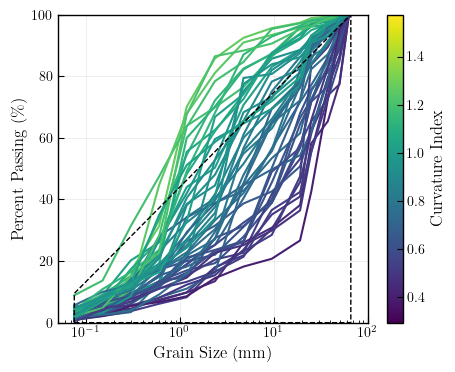

In [16]:
# c = q_ns, s = q_ns, cmap = "viridis"
fig, ax = plt.subplots()

color_param = "curvature_index"
color_index = df.columns.get_loc(color_param) + 1

# Get the colormap
cmap = plt.cm.viridis

# Normalize the i_gs values to [0, 1] range for the colormap
c_values = [row[color_index] for row in df.itertuples()]
c_min = min(c_values)
c_max = max(c_values)

n_sieves = [13]

for row in df.itertuples():
    x_data = row.GSD.sizes[1:]
    y_data = 100 * row.GSD.percent_passing[1:]

    # Normalize i_gs to [0, 1] range
    normalized_i_gs = (row[color_index] - c_min) / (c_max - c_min)

    # Get color from colormap
    color = cmap(normalized_i_gs)
    if row.n_sieves in n_sieves:
        ax.plot(x_data, y_data, color=color, alpha=1)

ax.plot(
    [0.075, 66, 66, 0.075, 0.075],
    [0, 0, 100, 9.5, 0],
    color="k",
    linestyle="--",
    linewidth=1,
    label="Uniform Distribution",
)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=c_min, vmax=c_max))
sm.set_array([])
colorbar = plt.colorbar(sm, ax=ax)
colorbar.set_label("Curvature Index")

ax.set_xscale("log")
ax.set_xlim(0.05, 100)
ax.set_ylim(0, 100)
ax.set_xlabel("Grain Size (mm)")
ax.set_ylabel(r"Percent Passing (\%)")


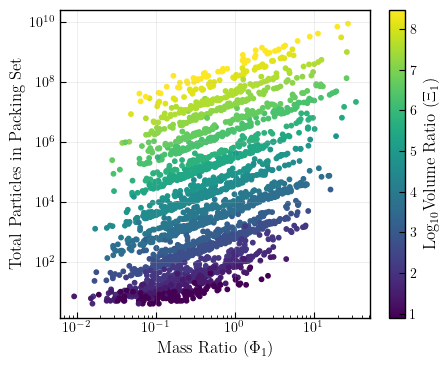

In [17]:
# c = q_ns, s = q_ns, cmap = "viridis"
color_param = "vol_ratio"
x_param = "mass_ratio"  # "curvature_index"
y_param = "total_particles"

fig, ax = plt.subplots()
ax.scatter(
    df[x_param],
    df[y_param],
    c=np.log10(df[color_param]),
    s=10,
    cmap="viridis",
    alpha=1,
)

# ax.legend(title="cu", loc='upper left', bbox_to_anchor=(1, 1))
colorbar = plt.colorbar(ax.collections[0], ax=ax)
colorbar.set_label(r"Log$_{10}$Volume Ratio ($\Xi_1$)")

ax.set_xlabel(r"Mass Ratio ($\Phi_1$)")
ax.set_ylabel("Total Particles in Packing Set")
ax.set_xscale("log")
ax.set_yscale("log")
# ax.grid(True, which="both", axis="both", alpha=0.25)


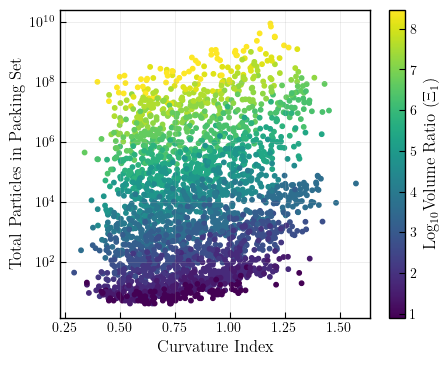

In [18]:
# c = q_ns, s = q_ns, cmap = "viridis"
color_param = "vol_ratio"
x_param = "curvature_index"
y_param = "total_particles"

fig, ax = plt.subplots()
ax.scatter(
    df[x_param],
    df[y_param],
    c=np.log10(df[color_param]),
    s=10,
    cmap="viridis",
    alpha=1,
)

# ax.legend(title="cu", loc='upper left', bbox_to_anchor=(1, 1))
colorbar = plt.colorbar(ax.collections[0], ax=ax)
colorbar.set_label(r"Log$_{10}$Volume Ratio ($\Xi_1$)")

ax.set_xlabel("Curvature Index")
ax.set_ylabel("Total Particles in Packing Set")
# ax.set_xscale("log")
ax.set_yscale("log")
# ax.grid(True, which='both', axis='both', alpha=0.25)


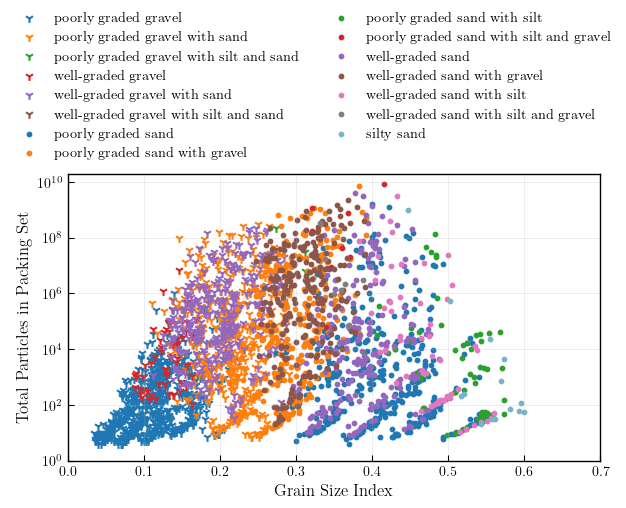

In [19]:
# plt.close("all")
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")

x_param = "gs_index"
y_param = "total_particles"
group_param = "group_name"
# df_plot = df[df[group_param].str.contains("")]

categories = ["graded gravel", "graded sand", "silty"]
markers = ["1", ".", "."]

for j, cat in enumerate(categories):
    df_plot = df[df[group_param].str.contains(cat)]

    if cat == "silty":
        palette = ["#77B3C9", "#F2A900"]
    else:
        palette = sns.color_palette()  # "Set2", len(df_plot[group_param].unique()))

    for i, (label, group) in enumerate(df_plot.groupby(group_param)):
        # if "graded gravel" in label:
        #     marker = "|"
        # else:
        #     marker = "_"
        ax.scatter(
            group[x_param],
            group[y_param],
            label=f"{label}",
            marker=markers[j],
            color=palette[i],
            # alpha=0.75,
            s=40,  # Scale point size by log_total_particles
        )


fig.legend(
    loc="outside upper center",
    fontsize="small",
    ncols=2,
    frameon=False,
    handlelength=2,
)

ax.set_xlabel("Grain Size Index")
ax.set_ylabel("Total Particles in Packing Set")
ax.set_ylim(1e0, 2e10)
ax.set_xlim(0.0, 0.7)
# ax.set_xlim(1e-2, 1e2)
# ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, which="both", axis="both")


In [13]:
# # c = q_ns, s = q_ns, cmap = "viridis"
# plt.close('all')
# fig, ax = plt.subplots(figsize=(10, 6))

# color_param = "cu"
# color_index = df.columns.get_loc(color_param) +1

# # Get the colormap
# cmap = plt.cm.jet

# # Normalize the i_gs values to [0, 1] range for the colormap
# c_values = [row[color_index] for row in df.itertuples()]
# c_min = min(c_values)
# c_max = max(c_values)

# n_sieves = [12]

# i = 0
# for row in df.itertuples():
#     x_data = row.GSD.sizes[1:]
#     y_data = 100 * row.GSD.percent_passing[1:]

#     # Normalize i_gs to [0, 1] range
#     normalized_i_gs = (row[color_index] - c_min) / (c_max - c_min)

#     # Get color from colormap
#     color = cmap(normalized_i_gs)
#     if row.n_sieves in n_sieves:
#         if i == 10:
#             ax.plot(x_data, y_data, color=color, marker="o", alpha=0.5)
#             ax.scatter([row.GSD.d_10], [10], color='red', s=50, label='d_10')
#             ax.scatter([row.GSD.d_30], [30], color='blue', s=50, label='d_30')
#             ax.scatter([row.GSD.d_60], [60], color='green', s=50, label='d_60')
#             print(row)
#         i += 1

# # Add colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=c_min, vmax=c_max))
# sm.set_array([])
# colorbar = plt.colorbar(sm, ax=ax)
# colorbar.set_label(color_param)

# ax.set_xscale("log")
# ax.set_xlabel("Log Size")
# ax.set_ylabel("GSD Curve")

In [14]:
# # c = q_ns, s = q_ns, cmap = "viridis"
# color_param = "curvature_index"
# x_param = "mass_ratio"
# y_param = "total_particles"

# fig, ax = plt.subplots()
# ax.scatter(
#     df[x_param],
#     df[y_param],
#     c=df[color_param],
#     s=7,  # np.log10(df["vol_ratio"]),
#     cmap="viridis",
#     alpha=0.7,
# )

# # ax.legend(title="cu", loc='upper left', bbox_to_anchor=(1, 1))
# colorbar = plt.colorbar(ax.collections[0], ax=ax)
# colorbar.set_label("Curvature Index")

# plt.rcParams["text.usetex"] = True

# ax.set_xlabel(r"Mass Ratio ($\Phi_1$)")
# ax.set_ylabel("Total Particles in Packing Set")
# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.grid(True, which="both", axis="both", alpha=0.25)
